## Back Test Results Binary Classification

In [1]:
import pandas as pd
from datetime import datetime, timezone
from pycaret.datasets import get_data
from pycaret.classification import *
import yaml
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
pycaret

<module 'pycaret' from '/usr/local/lib/python3.8/dist-packages/pycaret/__init__.py'>

In [3]:
with open ('back_test_pipeline_settings.yaml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    pair = cfg['currency']['pair_1']
    dt = cfg['model']['dt']
    et = cfg['model']['et']
    knn = cfg['model']['knn'] 
    rf = cfg['model']['rf']
    ada = cfg['model']['ada']
    gbc = cfg['model']['gbc']
    svm = cfg['model']['svm']
    lightgbm = cfg['model']['lightgbm']
    lr = cfg['model']['lr']
    ridge = cfg['model']['ridge']
    lda = cfg['model']['lda']
    qda = cfg['model']['qda']
    nb = cfg['model']['nb']
    frac = cfg['model']['frac']
    random_state = cfg['model']['random_state']

In [4]:
now = datetime.now()
today = now.strftime("%d-%m-%Y_%I-%M_%p")

In [5]:
dataset = pd.read_csv('01_Back_Test_Data.csv')
dataset.shape

(4000, 11)

In [6]:
dataset.head()

,Candle_No,Current_Market_Fit,Current_Market,Rec1_Score,Rec1_Prediction,Rec2_Score,Rec2_Prediction,Rec3_Score,Rec3_Prediction,Rec4_Score,Rec4_Prediction
0,7503.0,91.0,Bullish,30.132560,SELL,1.048709,BUY,72.021937,BUY,69.505226,SELL
1,5705.0,8.0,Bullish,26.758760,BUY,72.551481,SELL,86.985598,BUY,89.553882,BUY
2,4804.0,55.0,Bearish,89.916872,SELL,13.529732,SELL,87.949501,BUY,82.104354,SELL
3,7085.0,8.0,Bearish,69.243759,BUY,7.323873,BUY,61.932354,SELL,27.864543,SELL
4,8408.0,71.0,Bullish,60.641442,BUY,62.049823,SELL,0.898652,SELL,85.611362,BUY


## Drop Predictions with Less than 20% LR Fit

In [7]:
dataset = dataset[dataset['Current_Market_Fit'] > 20]
dataset = dataset.reset_index()
del dataset['index']

In [8]:
dataset.shape

(2861, 11)

## One-Hot Encoding

In [9]:
dataset['Current_Market'] = dataset['Current_Market'].replace(['Bullish','Bearish'],[1,0])
dataset['Rec1_Prediction'] = dataset['Rec1_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec2_Prediction'] = dataset['Rec2_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec3_Prediction'] = dataset['Rec3_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec4_Prediction'] = dataset['Rec4_Prediction'].replace(['BUY','SELL'],[1,-1])

In [10]:
dataset['Rec1_Score'] = dataset['Rec1_Score'] * dataset['Rec1_Prediction']
dataset['Rec2_Score'] = dataset['Rec2_Score'] * dataset['Rec2_Prediction']
dataset['Rec3_Score'] = dataset['Rec3_Score'] * dataset['Rec3_Prediction']
dataset['Rec4_Score'] = dataset['Rec4_Score'] * dataset['Rec4_Prediction']

In [11]:
dataset['Rec1_Score'] = dataset['Rec1_Score'].round(2)
dataset['Rec2_Score'] = dataset['Rec2_Score'].round(2)
dataset['Rec3_Score'] = dataset['Rec3_Score'].round(2)
dataset['Rec4_Score'] = dataset['Rec4_Score'].round(2)

In [12]:
dataset = dataset.drop([
    'Candle_No',
    'Current_Market_Fit',
    'Rec1_Prediction',
    'Rec2_Prediction',
    'Rec3_Prediction',
    'Rec4_Prediction',
], axis=1)

In [13]:
dataset.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score
0,1,-30.13,1.05,72.02,-69.51
1,0,-89.92,-13.53,87.95,-82.10
2,1,60.64,-62.05,-0.90,85.61
3,1,52.08,-48.12,-33.39,66.64
4,1,12.08,30.57,-45.50,73.95


In [14]:
data = dataset.sample(frac=frac, random_state=random_state).reset_index(drop=True)
data_unseen = dataset.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))
print('Fraction: ' + str(frac))
#print('Random State: ', str(random_state))

Data for Modeling: (2003, 5)
Unseen Data For Predictions: (858, 5)
Fraction: 0.7


# Create Unseen DataFrame

In [15]:
data_unseen.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score
0,1,15.87,87.34,1.54,38.33
1,0,-0.75,83.44,41.03,-10.81
2,0,96.62,-65.58,94.73,95.90
3,1,-60.60,-12.14,78.13,66.48
4,0,-8.21,4.48,-52.46,0.73


In [16]:
exp_name = setup(data = data,
                 target = 'Current_Market',
#                 fold_shuffle=True,
                 session_id=123,
                 silent=True,
 #                imputation_type='iterative'
                ) 

,Description,Value
0,session_id,123
1,Target,Current_Market
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(2003, 5)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [17]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.5143,0.5000,1.0000,0.5143,0.6792,0.0000,0.0000,0.0040
gbc,Gradient Boosting Classifier,0.5014,0.5049,0.5770,0.5147,0.5436,-0.0016,-0.0019,0.0500
catboost,CatBoost Classifier,0.4950,0.4898,0.5590,0.5077,0.5315,-0.0136,-0.0137,1.9940
ada,Ada Boost Classifier,0.4936,0.4747,0.5882,0.5072,0.5433,-0.0183,-0.0192,0.0350
knn,K Neighbors Classifier,0.4929,0.4987,0.5243,0.5067,0.5149,-0.0161,-0.0161,0.0120
svm,SVM - Linear Kernel,0.4921,0.0000,0.5104,0.5067,0.5078,-0.0170,-0.0171,0.0090
dt,Decision Tree Classifier,0.4915,0.4912,0.5022,0.5038,0.5024,-0.0175,-0.0173,0.0100
et,Extra Trees Classifier,0.4915,0.4903,0.5271,0.5054,0.5156,-0.0191,-0.0191,0.0860
lightgbm,Light Gradient Boosting Machine,0.4893,0.4846,0.5327,0.5025,0.5157,-0.0237,-0.0236,0.0280
xgboost,Extreme Gradient Boosting,0.4872,0.4852,0.5284,0.5021,0.5134,-0.0279,-0.0286,8.6600


DummyClassifier(constant=None, random_state=123, strategy='prior')

In [21]:
best_model = gbc

In [22]:
MODEL = create_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4752,0.4661,0.5833,0.4884,0.5316,-0.0546,-0.0557
1,0.5532,0.5093,0.5616,0.5694,0.5655,0.1057,0.1057
2,0.4786,0.4893,0.5972,0.4943,0.5409,-0.0501,-0.0514
3,0.5143,0.5083,0.5833,0.5250,0.5526,0.0246,0.0248
4,0.5000,0.4949,0.6111,0.5116,0.5570,-0.0066,-0.0067
5,0.5429,0.5603,0.5833,0.5526,0.5676,0.0835,0.0836
6,0.4714,0.5051,0.5417,0.4875,0.5132,-0.0615,-0.0619
7,0.5143,0.5504,0.5833,0.5250,0.5526,0.0246,0.0248
8,0.4857,0.5006,0.5833,0.5000,0.5385,-0.0345,-0.0350
9,0.4786,0.4644,0.5417,0.4937,0.5166,-0.0467,-0.0469


In [23]:
TUNED_MODEL = tune_model(MODEL)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4539,0.4199,0.5139,0.4684,0.4901,-0.0950,-0.0955
1,0.4681,0.4649,0.4384,0.4848,0.4604,-0.0614,-0.0617
2,0.5143,0.5114,0.5833,0.5250,0.5526,0.0246,0.0248
3,0.4929,0.5249,0.5139,0.5068,0.5103,-0.0155,-0.0155
4,0.5214,0.4561,0.5556,0.5333,0.5442,0.0409,0.0409
5,0.5357,0.5366,0.4861,0.5556,0.5185,0.0741,0.0747
6,0.5357,0.5398,0.5694,0.5467,0.5578,0.0695,0.0696
7,0.5357,0.5453,0.5417,0.5493,0.5455,0.0710,0.0711
8,0.6143,0.6483,0.6806,0.6125,0.6447,0.2254,0.2269
9,0.4714,0.4714,0.5000,0.4865,0.4932,-0.0589,-0.0589


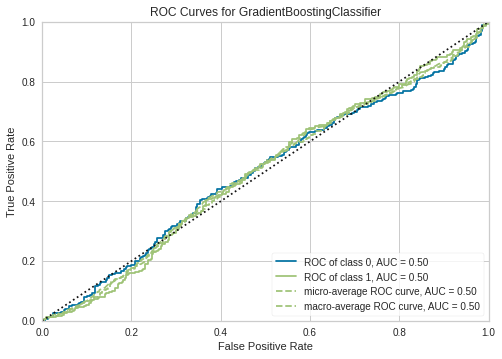

In [24]:
plot_model(TUNED_MODEL, plot = 'auc')

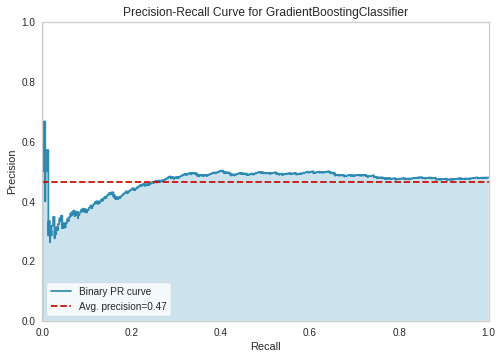

In [25]:
plot_model(TUNED_MODEL, plot = 'pr')

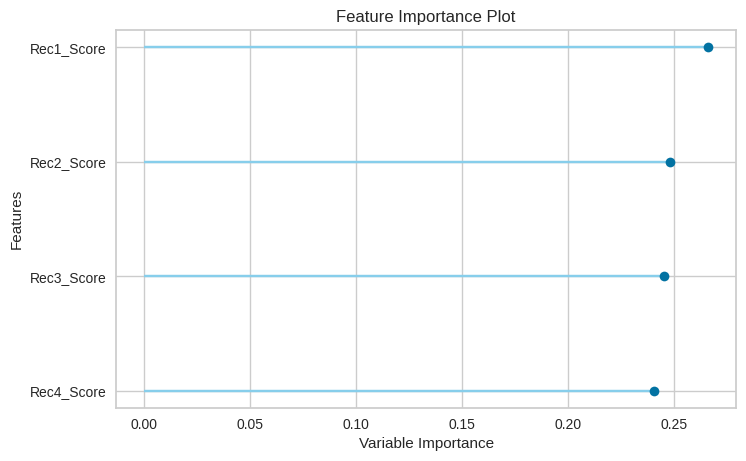

In [26]:
plot_model(TUNED_MODEL, plot='feature')

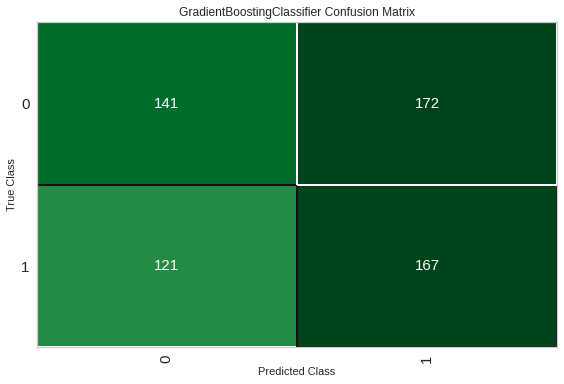

In [27]:
plot_model(TUNED_MODEL, plot = 'confusion_matrix')

In [28]:
predict_model(TUNED_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.5125,0.4976,0.5799,0.4926,0.5327,0.0301,0.0306


In [29]:
FINAL_MODEL = finalize_model(TUNED_MODEL)

In [30]:
print(FINAL_MODEL)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.3, loss='deviance', max_depth=5,
                           max_features=1.0, max_leaf_nodes=None,
                           min_impurity_decrease=0.0005,
                           min_impurity_split=None, min_samples_leaf=3,
                           min_samples_split=7, min_weight_fraction_leaf=0.0,
                           n_estimators=160, n_iter_no_change=None,
                           presort='deprecated', random_state=123,
                           subsample=0.45, tol=0.0001, validation_fraction=0.1,
                           verbose=0, warm_start=False)


In [31]:
predict_model(FINAL_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9800,0.9983,0.9757,0.9825,0.9791,0.9600,0.9600


In [32]:
unseen_predictions = predict_model(FINAL_MODEL, data=data_unseen)
unseen_predictions.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score,Label,Score
0,1,15.87,87.34,1.54,38.33,0,0.5105
1,0,-0.75,83.44,41.03,-10.81,0,0.9899
2,0,96.62,-65.58,94.73,95.90,0,0.9615
3,1,-60.60,-12.14,78.13,66.48,1,0.9832
4,0,-8.21,4.48,-52.46,0.73,0,0.6584


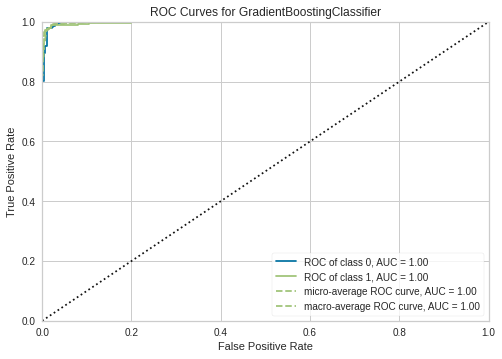

In [33]:
plot_model(FINAL_MODEL, plot = 'auc')

In [34]:
pkl_name = (today + "_" + best_model + "_" + pair)

In [35]:
save_model(FINAL_MODEL, pkl_name)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='Current_Market',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 nume...
                                             learning_rate=0.3, loss='deviance',
                                             max_depth=5, max_features=1.0,
                                             max_leaf_nodes=None,
            

In [36]:
SAVED_FINAL_MODEL = load_model(pkl_name)

Transformation Pipeline and Model Successfully Loaded


In [37]:
new_prediction = predict_model(SAVED_FINAL_MODEL, data=data_unseen)

In [38]:
new_prediction.head(20)

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score,Label,Score
0,1,15.87,87.34,1.54,38.33,0,0.5105
1,0,-0.75,83.44,41.03,-10.81,0,0.9899
2,0,96.62,-65.58,94.73,95.90,0,0.9615
3,1,-60.60,-12.14,78.13,66.48,1,0.9832
4,0,-8.21,4.48,-52.46,0.73,0,0.6584
5,0,-30.82,64.38,52.45,56.76,0,0.6947
6,1,-59.35,-57.29,72.37,-0.95,1,0.9135
7,1,-82.37,-72.34,1.81,-0.98,1,0.6949
8,0,-47.48,4.76,28.21,-20.69,1,0.7083
9,1,23.82,0.03,-19.04,-0.05,0,0.6643


In [39]:
file = open(today + "_" + "binary_classification_log_" + pair + ".txt", "w")
file.write ("Date: " + today + "\n" + \
            "Currency Pair: " + pair + "\n" + \
            "Model: " + best_model + "\n" + \
            "Frac: " + str(frac) + "\n" + \
            "Random State: " + str(random_state) + "\n" )
file.close()

/home/yekrangian/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/yekrangian/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/yekrangian/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/yekrangian/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/yekrangian/.local/lib/python3.8/site-packages/xgboost/sklearn.

/home/yekrangian/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/yekrangian/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/yekrangian/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/yekrangian/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/yekrangian/.local/lib/python3.8/site-packages/xgboost/sklearn.

/home/yekrangian/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/yekrangian/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/yekrangian/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/yekrangian/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/yekrangian/.local/lib/python3.8/site-packages/sklearn/utils/de